In [2]:
import numpy as numpy
import pandas as pd
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
import joblib

In [3]:
combined_train = pd.read_csv("combined_train.csv")
combined_test = pd.read_csv("combined_test.csv")
train_metadata = pd.read_csv("train/Features/train_metadata.csv")
test_metadata = pd.read_csv("test/Features/test_metadata.csv")

In [4]:
class_ids = train_metadata["ClassId"]
test_ids = test_metadata['id']
combined_train = combined_train.drop("image_path", axis = 1)
combined_test = combined_test.drop("image_path", axis=1)

Using a 'balanced' split after stratified folding doesn't really improve much

In [6]:
skf = StratifiedKFold()
scores = []
for train, validation in skf.split(combined_train, class_ids):
    model = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=8, criterion='entropy')
    model.fit(combined_train.iloc[train], class_ids[train])
    scores.append(model.score(combined_train.iloc[validation], class_ids[validation]))
print(scores)
print(sum(scores)/len(scores))
scores = []
for train, validation in skf.split(combined_train, class_ids):
    model = RandomForestClassifier(n_estimators=1000, n_jobs=8, criterion='entropy')
    model.fit(combined_train.iloc[train], class_ids[train])
    scores.append(model.score(combined_train.iloc[validation], class_ids[validation]))
print(scores)
print(sum(scores)/len(scores))

[0.819672131147541, 0.8041894353369763, 0.8360655737704918, 0.7994530537830447, 0.8258887876025525]
0.8170537963281213
[0.8096539162112932, 0.7987249544626593, 0.8278688524590164, 0.7912488605287147, 0.8222424794895169]
0.8099478126302401


Now for some hyperparameter tuning 

In [ ]:
n_estimators =  [50, 200, 500, 1000, 2000]
max_features = [0.2, 0.5, 'sqrt', "log2"]
max_depth = list(range(10, 111, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = 8, error_score='raise')
rf_random.fit(combined_train, class_ids)
joblib.dump(rf_random, "random_forest_random_search.pkl")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


['random_forest_random_search']

In [27]:
newnew = pd.DataFrame(rf_random.cv_results_)

In [34]:
newnew.sort_values(by="mean_test_score", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,519.720850,2.382786,1.112693,0.028023,2000,2,1,0.2,50,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.803825,0.802624,0.802078,0.802842,0.000730,1
21,107.869138,0.292672,0.533664,0.002658,1000,5,1,sqrt,20,False,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.786885,0.792236,0.788956,0.789359,0.002203,2
5,107.338174,0.566832,0.553966,0.004020,1000,5,2,sqrt,100,False,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.787978,0.787862,0.785675,0.787172,0.001059,3
74,495.678773,2.330150,1.241305,0.041978,2000,5,2,0.2,110,False,"{'n_estimators': 2000, 'min_samples_split': 5,...",0.785792,0.784582,0.786769,0.785714,0.000895,4
51,66.670618,0.105619,0.606207,0.028337,1000,2,2,log2,None,False,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.785792,0.787862,0.779114,0.784256,0.003733,5


Took me 100mins to run and its not even really better - test set performance pretty much the same too.

In [26]:
bestRF = rf_random.best_estimator_

In [13]:
def printSigns(accuracies, top_n, reverse=False):
    if reverse == True:
        accuracies = list(reversed(accuracies))
    for i in range(top_n):
        classID = accuracies[i][1]
        mpl.pyplot.subplot(2,top_n//2, i + 1)
        img = mpl.image.imread(f'Sign Images/{classID}.png')
        mpl.pyplot.imshow(img)
    mpl.pyplot.show()

No clue why the below code is broken! (Probably all the validation is contained within the train somehow)

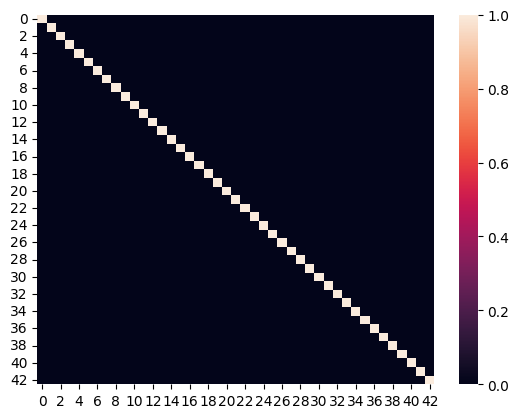

In [18]:
cm = confusion_matrix(class_ids[validation], bestRF.predict(combined_train.iloc[validation]), normalize='true')
sns.heatmap(cm)
class_accuracies = sorted((cm[i][i], i) for i in range(43))

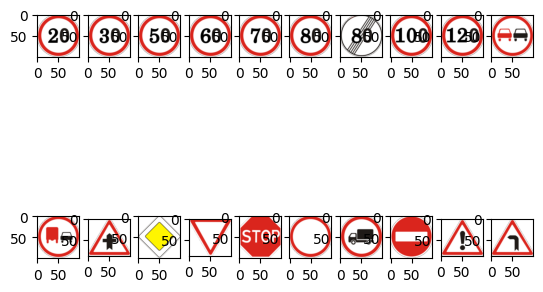

In [19]:
printSigns(class_accuracies, 20)

In [20]:
output = pd.DataFrame()
output["id"] = test_ids
output["ClassId"] = bestRF.predict(combined_test)
output.to_csv("output.csv", index=False)

In [21]:
output

,id,ClassId
0,661,12
1,4477,9
2,1046,2
3,631,7
4,6533,3
...,...,...
2348,2218,11
2349,4952,10
2350,1394,25
2351,3161,14
